### 資料轉換

#### 還沒有結束符號

In [17]:
import json

def parse_entities(raw_label):
    if raw_label.strip() == "PHI:Null":
        return {}

    entity_dict = {}
    for item in raw_label.strip().split("\\n"):
        if not item:
            continue
        if ':' not in item:
            continue
        key, value = item.split(":", 1)
        key = key.strip()
        value = value.strip()
        if key not in entity_dict:
            entity_dict[key] = []
        entity_dict[key].append(value)
    return entity_dict

def convert_tsv_to_jsonl(input_path, output_path):
    with open(input_path, "r", encoding="utf-8") as infile, \
         open(output_path, "w", encoding="utf-8") as outfile:

        for line in infile:
            parts = line.strip().split("\t")
            if len(parts) != 3:
                continue
            example_id, text, raw_label = parts
            entities = parse_entities(raw_label)
            output_obj = {
                "id": example_id,  # ✅ 加上音檔對應的 ID
                "input": f"Extract sensitive information (e.g., names, dates, professions, etc.) from the following text and respond in JSON format.\nText: {text}",
                "output": json.dumps(entities, ensure_ascii=False)
            }
            json_line = json.dumps(output_obj, ensure_ascii=False)
            outfile.write(json_line + "\n")

    print(f"✅ Finished! JSONL with IDs saved at: {output_path}")

# === 執行轉換 ===
convert_tsv_to_jsonl("/home/student1/ai/train3/task2_train.tsv", "train_with_id.jsonl")


✅ Finished! JSONL with IDs saved at: train_with_id.jsonl


### 訓練

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/1168 [00:00<?, ? examples/s]

Map:   0%|          | 0/293 [00:00<?, ? examples/s]

/home/student1/miniconda3/envs/lin/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/tmp/ipykernel_207326/2939827369.py:89: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


Epoch,Training Loss,Validation Loss
1,1.857100,1.843284
2,1.725600,1.759868
3,1.613700,1.756223
4,1.550600,1.772328
5,1.497200,1.808820


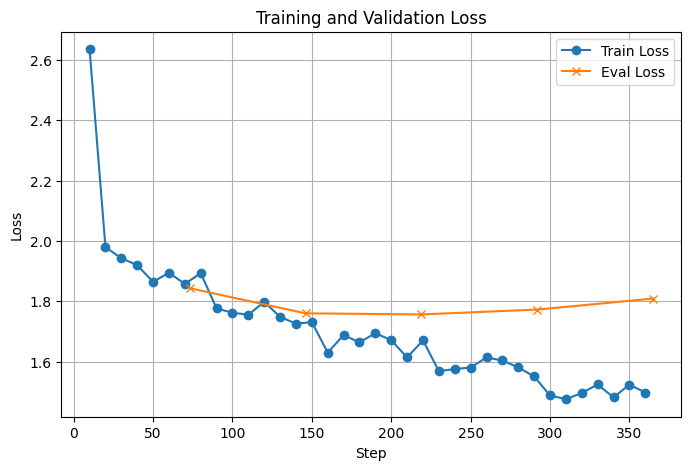

In [ ]:
import json 
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset, DatasetDict
from transformers import (
    AutoTokenizer, AutoModelForCausalLM, AutoConfig,
    TrainingArguments, Trainer, DataCollatorForLanguageModeling,
    EarlyStoppingCallback
)
from peft import LoraConfig, get_peft_model, TaskType
from accelerate import init_empty_weights, infer_auto_device_map
import torch

# === 基本參數 ===
model_id = "mistralai/Mistral-7B-Instruct-v0.2"
jsonl_path = "/home/student1/ai/train_with_id.jsonl"
output_dir = "/home/student1/ai/mistral7b-phi-lora"

# === 載入資料集並切分 ===
raw_dataset = load_dataset("json", data_files={"data": jsonl_path})["data"]
raw_dataset = raw_dataset.shuffle(seed=42)
split_dataset = raw_dataset.train_test_split(test_size=0.2)
dataset = DatasetDict({
    "train": split_dataset["train"],
    "validation": split_dataset["test"]
})

# === 載入 tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

# === 安全載入模型結構並配置 device_map ===
config = AutoConfig.from_pretrained(model_id, trust_remote_code=True)
with init_empty_weights():
    empty_model = AutoModelForCausalLM.from_config(config, trust_remote_code=True)
device_map = infer_auto_device_map(empty_model, max_memory={0: "22GiB", "cpu": "32GiB"}, no_split_module_classes=["MistralDecoderLayer"])

# === 載入模型並加上 device_map ===
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map=device_map,
    trust_remote_code=True
)

# === 加入 LoRA 模組 ===
lora_config = LoraConfig(
    r=8,
    lora_alpha=16,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.CAUSAL_LM
)
model = get_peft_model(model, lora_config)

# === Tokenize 輸入與輸出 ===
def tokenize(example):
    text = example["input"] + "\n" + example["output"]
    return tokenizer(text, truncation=True, padding="max_length", max_length=512)

columns_to_remove = [col for col in dataset["train"].column_names if col in ["input", "output", "id"]]
tokenized_dataset = dataset.map(tokenize, remove_columns=columns_to_remove)

# === 訓練參數 ===
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=10,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=8,
    num_train_epochs=10,
    learning_rate=2e-4,
    fp16=True,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    report_to="none",
    overwrite_output_dir=True
)

# === 建立 Trainer ===
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# === 開始訓練 ===
trainer.train()

# === 儲存 loss 並繪圖 ===
log_df = pd.DataFrame(trainer.state.log_history)
log_df.to_csv(f"{output_dir}/loss_log.csv", index=False)

plt.figure(figsize=(8, 5))
if "loss" in log_df.columns:
    train_loss = log_df[log_df["loss"].notnull()]
    plt.plot(train_loss["step"], train_loss["loss"], label="Train Loss", marker='o')
if "eval_loss" in log_df.columns:
    eval_loss = log_df[log_df["eval_loss"].notnull()]
    plt.plot(eval_loss["step"], eval_loss["eval_loss"], label="Eval Loss", marker='x')
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig(f"{output_dir}/loss_plot.png")
plt.show()


### 推論測試

In [5]:
import torch 
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import json
import re

# === 基本參數 ===
base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
lora_model_path = "/home/student1/ai/mistral7b-phi-lora/checkpoint-365"

# === 載入 tokenizer 與模型（含 LoRA） ===
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)
model = PeftModel.from_pretrained(model, lora_model_path)
model.eval()

# === 測試輸入 ===
text = "We visited Dr. Chen at Taipei General Hospital on January 3rd."

phi_labels = [
    'PATIENT', 'DOCTOR', 'USERNAME', 'FAMILYNAME', 'PERSONALNAME', 'PROFESSION',
    'ROOM', 'DEPARTMENT', 'HOSPITAL', 'ORGANIZATION', 'STREET', 'CITY',
    'DISTRICT', 'COUNTY', 'STATE', 'COUNTRY', 'ZIP', 'LOCATION-OTHER',
    'AGE', 'DATE', 'TIME', 'DURATION', 'SET',
    'PHONE', 'FAX', 'EMAIL', 'URL', 'IPADDRESS',
    'SOCIAL_SECURITY_NUMBER', 'MEDICAL_RECORD_NUMBER', 'HEALTH_PLAN_NUMBER', 'ACCOUNT_NUMBER',
    'LICENSE_NUMBER', 'VEHICLE_ID', 'DEVICE_ID', 'BIOMETRIC_ID', 'ID_NUMBER',
    'OTHER'
]

# === 強化 prompt，避免重複生成
prompt = f"""You are an information extraction assistant.
Extract the following sensitive entities from the input text: {', '.join(phi_labels)}.
Only extract information that is explicitly stated in the input text. Do not assume or infer. Respond with a single valid JSON object.

Text: {text}
Answer:"""


# === 推論 ===
inputs = tokenizer(prompt, return_tensors="pt").to(model.device)
with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=256,
        temperature=0.2,
        do_sample=False
    )

decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

# === 後處理：抽出第一段合法 JSON ===
def extract_first_json(text):
    matches = re.findall(r"\{.*?\}", text, re.DOTALL)
    for m in matches:
        try:
            return json.loads(m)
        except:
            continue
    return {}

result_json = extract_first_json(decoded)

# === 顯示乾淨輸出 ===
print("\n✅ Cleaned Prediction:\n")
print(json.dumps(result_json, indent=2, ensure_ascii=False))


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.
Some parameters are on the meta device because they were offloaded to the cpu.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



✅ Cleaned Prediction:

{
  "DOCTOR": [
    "Chen"
  ],
  "DATE": [
    "January 3rd"
  ],
  "HOSPITAL": [
    "Taipei General Hospital"
  ]
}


### 推論整個answer1

### 0.26

In [5]:
import torch  
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import json
import os

# === 基本參數 ===
base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
lora_model_path = "/home/student1/ai/mistral7b-phi-lora/checkpoint-365"
input_file = "/home/student1/ai/task1_answer.txt"
output_file = "/home/student1/ai/task1_prediction.json"
batch_size = 4  # 可調整

# === 載入模型與 tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
model = PeftModel.from_pretrained(model, lora_model_path)
model.eval()

# === PHI 標籤 ===
phi_labels = [
    'PATIENT', 'DOCTOR', 'USERNAME', 'FAMILYNAME', 'PERSONALNAME', 'PROFESSION',
    'ROOM', 'DEPARTMENT', 'HOSPITAL', 'ORGANIZATION', 'STREET', 'CITY',
    'DISTRICT', 'COUNTY', 'STATE', 'COUNTRY', 'ZIP', 'LOCATION-OTHER',
    'AGE', 'DATE', 'TIME', 'DURATION', 'SET',
    'PHONE', 'FAX', 'EMAIL', 'URL', 'IPADDRESS',
    'SOCIAL_SECURITY_NUMBER', 'MEDICAL_RECORD_NUMBER', 'HEALTH_PLAN_NUMBER', 'ACCOUNT_NUMBER',
    'LICENSE_NUMBER', 'VEHICLE_ID', 'DEVICE_ID', 'BIOMETRIC_ID', 'ID_NUMBER',
    'OTHER'
]

# === 讀取資料並製作 Prompt ===
data = []
with open(input_file, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        uid, text = line.strip().split("\t", 1)
        prompt = f"""You are an information extraction assistant. Extract the following sensitive entities explicitly mentioned in the input text. Respond strictly in JSON format with categories as keys and lists of extracted values.

Definitions and examples:
- PATIENT, DOCTOR, PERSONALNAME, FAMILYNAME: Person names including patients, doctors, family members. Example: "Dr. Chen", "James"
- PROFESSION: Job titles or professions, e.g., "pastor", "psychologist"
- HOSPITAL: Names of hospitals or medical centers, e.g., "Taipei General Hospital"
- ORGANIZATION: Names of organizations or companies, e.g., "Cambridge University"
- STREET: Street addresses or road names, e.g., "Main Street"
- CITY: City or town names, e.g., "New York"
- STATE: State or province names, e.g., "California", "New South Wales"
- ZIP: Postal or ZIP codes, e.g., "90210"
- AGE: Ages or durations of life, e.g., "25 years old", "six months"
- DATE: Calendar dates in any format, e.g., "June 1, 1990", "2023-05-10"
- TIME: Times of day or time periods, e.g., "09:03 AM", "evening"
- DURATION: Lengths of time intervals, e.g., "two hours", "last week"
- ID_NUMBER: Identification numbers such as social security or medical record numbers, e.g., "A123456789", "123-45-6789"
- PHONE, FAX, EMAIL, URL, IPADDRESS: Contact and network info
- OTHER: Any other sensitive information not covered above

Text: {text}

Answer:
"""
        data.append((uid, prompt))

# === 分批推論函式 ===
def batch_predict(batch_prompts):
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.2,
            do_sample=False
        )
    decoded_list = [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]
    return decoded_list

# === 主推論流程，每批存檔 ===
predictions = {}

for i in range(0, len(data), batch_size):
    batch = data[i:i+batch_size]
    uids, prompts = zip(*batch)
    decoded_outputs = batch_predict(prompts)

    for uid, decoded in zip(uids, decoded_outputs):
        try:
            json_start = decoded.index("{")
            json_str = decoded[json_start:]
            parsed = json.loads(json_str)
        except Exception:
            parsed = {}
        predictions[uid] = parsed

    # 每批寫檔一次，覆蓋檔案
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(predictions, f, ensure_ascii=False, indent=2)

    print(f"✅ 已完成第 {i // batch_size + 1} 批，累積 {len(predictions)} 筆結果寫入 {output_file}")

print(f"🎉 全部預測完成，結果已存於 {output_file}")


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the cpu.
Some parameters are on the meta device because they were offloaded to the cpu.
Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 1 批，累積 4 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 2 批，累積 8 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 3 批，累積 12 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 4 批，累積 16 筆結果寫入 /home/student1/ai/task1_prediction.json


KeyboardInterrupt: 

### 0.397


In [ ]:
import torch  
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import json
import os

# === 基本參數 ===
base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
lora_model_path = "/home/student1/ai/mistral7b-phi-lora/checkpoint-365"
input_file = "/home/student1/ai/task1_answer.txt"
output_file = "/home/student1/ai/task1_prediction.json"
batch_size = 4  # 可調整

# === 載入模型與 tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
model = PeftModel.from_pretrained(model, lora_model_path)
model.eval()

# === PHI 標籤 ===
phi_labels = [
    'PATIENT', 'DOCTOR', 'USERNAME', 'FAMILYNAME', 'PERSONALNAME', 'PROFESSION',
    'ROOM', 'DEPARTMENT', 'HOSPITAL', 'ORGANIZATION', 'STREET', 'CITY',
    'DISTRICT', 'COUNTY', 'STATE', 'COUNTRY', 'ZIP', 'LOCATION-OTHER',
    'AGE', 'DATE', 'TIME', 'DURATION', 'SET',
    'PHONE', 'FAX', 'EMAIL', 'URL', 'IPADDRESS',
    'SOCIAL_SECURITY_NUMBER', 'MEDICAL_RECORD_NUMBER', 'HEALTH_PLAN_NUMBER', 'ACCOUNT_NUMBER',
    'LICENSE_NUMBER', 'VEHICLE_ID', 'DEVICE_ID', 'BIOMETRIC_ID', 'ID_NUMBER',
    'OTHER'
]

# === 讀取資料並製作 Prompt ===
data = []
with open(input_file, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        uid, text = line.strip().split("\t", 1)
        prompt = f"""You are an information extraction assistant. Extract the following sensitive entities explicitly mentioned in the input text. Respond strictly in JSON format with categories as keys and lists of extracted values.

Definitions and examples:
- PATIENT, DOCTOR, PERSONALNAME, FAMILYNAME: Person names including patients, doctors, family members. Example: "Dr. Chen", "James"
- PROFESSION: Job titles or professions, e.g., "pastor", "psychologist"
- HOSPITAL: Names of hospitals or medical centers, e.g., "Taipei General Hospital"
- ORGANIZATION: Names of organizations or companies, e.g., "Cambridge University"
- STREET: Street addresses or road names, e.g., "Main Street"
- CITY: City or town names, e.g., "New York"
- STATE: State or province names, e.g., "California", "New South Wales"
- ZIP: Postal or ZIP codes, e.g., "90210"
- AGE: Ages or durations of life, e.g., "25 years old", "six months"
- DATE: Calendar dates in any format, e.g., "June 1, 1990", "2023-05-10"
- TIME: Times of day or time periods, e.g., "09:03 AM", "evening", "morning"
- DURATION: Lengths of time intervals, e.g., "two hours", "last week"
- ID_NUMBER: Identification numbers such as social security or medical record numbers, e.g., "A123456789", "123-45-6789"
- PHONE, FAX, EMAIL, URL, IPADDRESS: Contact and network info
- OTHER: Any other sensitive information not covered above
- COUNTRY: Countries such as "United States", "Australia", "Japan"
- COUNTY: Administrative regions smaller than states but larger than cities, e.g., "Los Angeles County", "Orange County"
- DISTRICT: Smaller political or administrative divisions, e.g., "Manhattan District", "Central District"
- LOCATION-OTHER: Neighborhoods, landmarks, or other places not covered above, e.g., "Downtown", "Central Park", "Financial District"

Text: {text}

Answer:
"""
        data.append((uid, prompt))

# === 分批推論函式 ===
def batch_predict(batch_prompts):
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.2,
            do_sample=False
        )
    decoded_list = [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]
    return decoded_list

# === 主推論流程，每批存檔 ===
predictions = {}

for i in range(0, len(data), batch_size):
    batch = data[i:i+batch_size]
    uids, prompts = zip(*batch)
    decoded_outputs = batch_predict(prompts)

    for uid, decoded in zip(uids, decoded_outputs):
        try:
            json_start = decoded.index("{")
            json_str = decoded[json_start:]
            parsed = json.loads(json_str)
        except Exception:
            parsed = {}
        predictions[uid] = parsed

    # 每批寫檔一次，覆蓋檔案
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(predictions, f, ensure_ascii=False, indent=2)

    print(f"✅ 已完成第 {i // batch_size + 1} 批，累積 {len(predictions)} 筆結果寫入 {output_file}")

print(f"🎉 全部預測完成，結果已存於 {output_file}")



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/home/student1/miniconda3/envs/lin/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 1 批，累積 4 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 2 批，累積 8 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 3 批，累積 12 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 4 批，累積 16 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 5 批，累積 20 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 6 批，累積 24 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 7 批，累積 28 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 8 批，累積 32 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 9 批，累積 36 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 10 批，累積 40 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 11 批，累積 44 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 12 批，累積 48 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 13 批，累積 52 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 14 批，累積 56 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 15 批，累積 60 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 16 批，累積 64 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 17 批，累積 68 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 18 批，累積 72 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 19 批，累積 76 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 20 批，累積 80 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 21 批，累積 84 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 22 批，累積 88 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 23 批，累積 92 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 24 批，累積 96 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 25 批，累積 100 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 26 批，累積 104 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 27 批，累積 108 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 28 批，累積 112 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 29 批，累積 116 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 30 批，累積 120 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 31 批，累積 124 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 32 批，累積 128 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 33 批，累積 132 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 34 批，累積 136 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 35 批，累積 140 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 36 批，累積 144 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 37 批，累積 148 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 38 批，累積 152 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 39 批，累積 156 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 40 批，累積 160 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 41 批，累積 164 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 42 批，累積 168 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 43 批，累積 172 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 44 批，累積 176 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 45 批，累積 180 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 46 批，累積 184 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 47 批，累積 188 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 48 批，累積 192 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 49 批，累積 196 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 50 批，累積 200 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 51 批，累積 204 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 52 批，累積 208 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 53 批，累積 212 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 54 批，累積 216 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 55 批，累積 220 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 56 批，累積 224 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 57 批，累積 228 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 58 批，累積 232 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 59 批，累積 236 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 60 批，累積 240 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 61 批，累積 244 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 62 批，累積 248 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 63 批，累積 252 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 64 批，累積 256 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 65 批，累積 260 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 66 批，累積 264 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 67 批，累積 268 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 68 批，累積 272 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 69 批，累積 276 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 70 批，累積 280 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 71 批，累積 284 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 72 批，累積 288 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 73 批，累積 292 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 74 批，累積 296 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 75 批，累積 300 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 76 批，累積 304 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 77 批，累積 308 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 78 批，累積 312 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 79 批，累積 316 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 80 批，累積 320 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 81 批，累積 324 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 82 批，累積 328 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 83 批，累積 332 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 84 批，累積 336 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 85 批，累積 340 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 86 批，累積 344 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 87 批，累積 348 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 88 批，累積 352 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 89 批，累積 356 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 90 批，累積 360 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 91 批，累積 364 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 92 批，累積 368 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 93 批，累積 372 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 94 批，累積 376 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 95 批，累積 380 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 96 批，累積 384 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 97 批，累積 388 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 98 批，累積 392 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 99 批，累積 396 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 100 批，累積 400 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 101 批，累積 404 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 102 批，累積 408 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 103 批，累積 412 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 104 批，累積 416 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 105 批，累積 420 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 106 批，累積 424 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 107 批，累積 428 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 108 批，累積 432 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 109 批，累積 436 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 110 批，累積 440 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 111 批，累積 444 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 112 批，累積 448 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 113 批，累積 452 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 114 批，累積 456 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 115 批，累積 460 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 116 批，累積 464 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 117 批，累積 468 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 118 批，累積 472 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 119 批，累積 476 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 120 批，累積 480 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 121 批，累積 484 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 122 批，累積 488 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 123 批，累積 492 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 124 批，累積 496 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 125 批，累積 500 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 126 批，累積 504 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 127 批，累積 508 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 128 批，累積 512 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 129 批，累積 516 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 130 批，累積 520 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 131 批，累積 524 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 132 批，累積 528 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 133 批，累積 532 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 134 批，累積 536 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 135 批，累積 540 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 136 批，累積 544 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 137 批，累積 548 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 138 批，累積 552 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 139 批，累積 556 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 140 批，累積 560 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 141 批，累積 564 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 142 批，累積 568 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 143 批，累積 572 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 144 批，累積 576 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 145 批，累積 580 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 146 批，累積 584 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 147 批，累積 588 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 148 批，累積 592 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 149 批，累積 596 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 150 批，累積 600 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 151 批，累積 604 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 152 批，累積 608 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 153 批，累積 612 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 154 批，累積 616 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 155 批，累積 620 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 156 批，累積 624 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 157 批，累積 628 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 158 批，累積 632 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 159 批，累積 636 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 160 批，累積 640 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 161 批，累積 644 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 162 批，累積 648 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 163 批，累積 652 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 164 批，累積 656 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 165 批，累積 660 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 166 批，累積 664 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 167 批，累積 668 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 168 批，累積 672 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 169 批，累積 676 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 170 批，累積 680 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 171 批，累積 684 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 172 批，累積 688 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 173 批，累積 692 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 174 批，累積 696 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 175 批，累積 700 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 176 批，累積 704 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 177 批，累積 708 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 178 批，累積 712 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 179 批，累積 716 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 180 批，累積 720 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 181 批，累積 724 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 182 批，累積 728 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 183 批，累積 732 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 184 批，累積 736 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 185 批，累積 740 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 186 批，累積 744 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 187 批，累積 748 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 188 批，累積 752 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 189 批，累積 756 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 190 批，累積 760 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 191 批，累積 764 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 192 批，累積 768 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 193 批，累積 772 筆結果寫入 /home/student1/ai/task1_prediction.json
✅ 已完成第 194 批，累積 775 筆結果寫入 /home/student1/ai/task1_prediction.json
🎉 全部預測完成，結果已存於 /home/student1/ai/task1_prediction.json


### 0.3882

In [1]:
import torch  
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import json
import os

# === 基本參數 ===
base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
lora_model_path = "/home/student1/ai/mistral7b-phi-lora/checkpoint-365"
input_file = "/home/student1/ai/task1_answer.txt"
output_file = "/home/student1/ai/task1_prediction.json"
batch_size = 4  # 可調整

# === 載入模型與 tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
model = PeftModel.from_pretrained(model, lora_model_path)
model.eval()

# === PHI 標籤 ===
phi_labels = [
    'PATIENT', 'DOCTOR', 'USERNAME', 'FAMILYNAME', 'PERSONALNAME', 'PROFESSION',
    'ROOM', 'DEPARTMENT', 'HOSPITAL', 'ORGANIZATION', 'STREET', 'CITY',
    'DISTRICT', 'COUNTY', 'STATE', 'COUNTRY', 'ZIP', 'LOCATION-OTHER',
    'AGE', 'DATE', 'TIME', 'DURATION', 'SET',
    'PHONE', 'FAX', 'EMAIL', 'URL', 'IPADDRESS',
    'SOCIAL_SECURITY_NUMBER', 'MEDICAL_RECORD_NUMBER', 'HEALTH_PLAN_NUMBER', 'ACCOUNT_NUMBER',
    'LICENSE_NUMBER', 'VEHICLE_ID', 'DEVICE_ID', 'BIOMETRIC_ID', 'ID_NUMBER',
    'OTHER'
]

# === 讀取資料並製作 Prompt ===
data = []
with open(input_file, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        uid, text = line.strip().split("\t", 1)
        prompt = f"""You are an information extraction assistant. Extract the following sensitive entities explicitly mentioned in the input text. Respond strictly in JSON format with categories as keys and lists of extracted values.

Definitions and examples:
- **PATIENT**: A person who is receiving medical treatment or care. This can refer to someone in a healthcare context, such as "patient John Doe" or "Mr. Lee, the patient". 
  Example: "Patient John Doe was admitted for a heart procedure."
  
- **DOCTOR**: A medical professional who is diagnosing or treating patients. This may include titles like "Dr." or "Physician". 
  Example: "Dr. Smith examined the patient."

- **PERSONALNAME**: A general person name that can refer to anyone. This can include both first names and full names.
  Example: "James" or "Mary Johnson"

- **FAMILYNAME**: The last name or surname of a person, often found as the first part of a full name.
  Example: "Doe" in "John Doe" or "Chen" in "Li Chen".

- **PROFESSION**: Job titles or professions, e.g., "pastor", "psychologist", "chiropractor", "teacher", "engineer".
  Example: "He is a skilled **psychologist**."

- **HOSPITAL**: Names of hospitals or medical centers, e.g., "Taipei General Hospital", "Memorial Hospital".
  Example: "The patient was transferred to **Taipei General Hospital**."

- **ORGANIZATION**: Names of organizations or companies, e.g., "Cambridge University", "Microsoft", "YMCA", "Bank of America".
  Example: "She works at **Bank of America**."

- **STREET**: Street addresses or road names, e.g., "Main Street", "Elm Street".
  Example: "Their office is located on **Main Street**."

- **CITY**: City or town names, e.g., "New York", "Los Angeles".
  Example: "I live in **New York**."

- **STATE**: State or province names, e.g., "California", "New South Wales".
  Example: "He moved to **California** last year."

- **ZIP**: Postal or ZIP codes, e.g., "90210".
  Example: "The ZIP code for my address is **90210**."

- **AGE**: Ages or durations of life, e.g., "25 years old", "six months".
  Example: "She is **25 years old**."

- **DATE**: Calendar dates in any format, e.g., "June 1, 1990", "2023-05-10".
  Example: "The event is scheduled for **2023-05-10**."

- **TIME**: Times of day or time periods, e.g., "09:03 AM", "evening", "morning".
  Example: "The meeting starts at **09:03 AM**."

- **DURATION**: Lengths of time intervals, e.g., "two hours", "last week".
  Example: "The treatment lasted for **two hours**."

- **ID_NUMBER**: Identification numbers such as social security or medical record numbers, e.g., "A123456789", "123-45-6789".
  Example: "Her medical record number is **A123456789**."

- **PHONE, FAX, EMAIL, URL, IPADDRESS**: Contact and network info.
  Example: "You can contact him at **john.doe@example.com**."

- **OTHER**: Any other sensitive information not covered above.
  Example: "The patient's **insurance policy number** is **123456789**."

- **COUNTRY**: Countries such as "United States", "Australia", "Japan".
  Example: "He moved from **Japan** to **Australia**."

- **COUNTY**: Administrative regions smaller than states but larger than cities, e.g., "Los Angeles County", "Orange County".
  Example: "**Los Angeles County** has many scenic locations."

- **DISTRICT**: Smaller political or administrative divisions, e.g., "Manhattan District", "Central District".
  Example: "I live in the **Manhattan District**."

- **LOCATION-OTHER**: Neighborhoods, landmarks, or other places not covered above, e.g., "Downtown", "Central Park", "Financial District".
  Example: "We met in **Central Park**."

Text: {text}

Answer:
"""

        data.append((uid, prompt))

# === 分批推論函式 ===
def batch_predict(batch_prompts):
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.2,
            do_sample=False
        )
    decoded_list = [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]
    return decoded_list

# === 主推論流程，每批存檔 ===
predictions = {}

for i in range(0, len(data), batch_size):
    batch = data[i:i+batch_size]
    uids, prompts = zip(*batch)
    decoded_outputs = batch_predict(prompts)

    for uid, decoded in zip(uids, decoded_outputs):
        try:
            json_start = decoded.index("{")
            json_str = decoded[json_start:]
            parsed = json.loads(json_str)
        except Exception:
            parsed = {}
        predictions[uid] = parsed

    # 每批寫檔一次，覆蓋檔案
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(predictions, f, ensure_ascii=False, indent=2)

    print(f"✅ 已完成第 {i // batch_size + 1} 批，累積 {len(predictions)} 筆結果寫入 {output_file}")

print(f"🎉 全部預測完成，結果已存於 {output_file}")



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/home/student1/miniconda3/envs/lin/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 1 批，累積 4 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 2 批，累積 8 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 3 批，累積 12 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 4 批，累積 16 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 5 批，累積 20 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 6 批，累積 24 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 7 批，累積 28 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 8 批，累積 32 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 9 批，累積 36 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 10 批，累積 40 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 11 批，累積 44 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 12 批，累積 48 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 13 批，累積 52 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 14 批，累積 56 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 15 批，累積 60 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 16 批，累積 64 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 17 批，累積 68 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 18 批，累積 72 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 19 批，累積 76 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 20 批，累積 80 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 21 批，累積 84 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 22 批，累積 88 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 23 批，累積 92 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 24 批，累積 96 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 25 批，累積 100 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 26 批，累積 104 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 27 批，累積 108 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 28 批，累積 112 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 29 批，累積 116 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 30 批，累積 120 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 31 批，累積 124 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 32 批，累積 128 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 33 批，累積 132 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 34 批，累積 136 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 35 批，累積 140 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 36 批，累積 144 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 37 批，累積 148 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 38 批，累積 152 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 39 批，累積 156 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 40 批，累積 160 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 41 批，累積 164 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 42 批，累積 168 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 43 批，累積 172 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 44 批，累積 176 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 45 批，累積 180 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 46 批，累積 184 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 47 批，累積 188 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 48 批，累積 192 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 49 批，累積 196 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 50 批，累積 200 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 51 批，累積 204 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 52 批，累積 208 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 53 批，累積 212 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 54 批，累積 216 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 55 批，累積 220 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 56 批，累積 224 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 57 批，累積 228 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 58 批，累積 232 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 59 批，累積 236 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 60 批，累積 240 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 61 批，累積 244 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 62 批，累積 248 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 63 批，累積 252 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 64 批，累積 256 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 65 批，累積 260 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 66 批，累積 264 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 67 批，累積 268 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 68 批，累積 272 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 69 批，累積 276 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 70 批，累積 280 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 71 批，累積 284 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 72 批，累積 288 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 73 批，累積 292 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 74 批，累積 296 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 75 批，累積 300 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 76 批，累積 304 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 77 批，累積 308 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 78 批，累積 312 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 79 批，累積 316 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 80 批，累積 320 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 81 批，累積 324 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 82 批，累積 328 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 83 批，累積 332 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 84 批，累積 336 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 85 批，累積 340 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 86 批，累積 344 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 87 批，累積 348 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 88 批，累積 352 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 89 批，累積 356 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 90 批，累積 360 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 91 批，累積 364 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 92 批，累積 368 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 93 批，累積 372 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 94 批，累積 376 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 95 批，累積 380 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 96 批，累積 384 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 97 批，累積 388 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 98 批，累積 392 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 99 批，累積 396 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 100 批，累積 400 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 101 批，累積 404 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 102 批，累積 408 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 103 批，累積 412 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 104 批，累積 416 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 105 批，累積 420 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 106 批，累積 424 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 107 批，累積 428 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 108 批，累積 432 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 109 批，累積 436 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 110 批，累積 440 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 111 批，累積 444 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 112 批，累積 448 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 113 批，累積 452 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 114 批，累積 456 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 115 批，累積 460 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 116 批，累積 464 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 117 批，累積 468 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 118 批，累積 472 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 119 批，累積 476 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 120 批，累積 480 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 121 批，累積 484 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 122 批，累積 488 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 123 批，累積 492 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 124 批，累積 496 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 125 批，累積 500 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 126 批，累積 504 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 127 批，累積 508 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 128 批，累積 512 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 129 批，累積 516 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 130 批，累積 520 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 131 批，累積 524 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 132 批，累積 528 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 133 批，累積 532 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 134 批，累積 536 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 135 批，累積 540 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 136 批，累積 544 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 137 批，累積 548 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 138 批，累積 552 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 139 批，累積 556 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 140 批，累積 560 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 141 批，累積 564 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 142 批，累積 568 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 143 批，累積 572 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 144 批，累積 576 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 145 批，累積 580 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 146 批，累積 584 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 147 批，累積 588 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 148 批，累積 592 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 149 批，累積 596 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 150 批，累積 600 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 151 批，累積 604 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 152 批，累積 608 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 153 批，累積 612 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 154 批，累積 616 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 155 批，累積 620 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 156 批，累積 624 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 157 批，累積 628 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 158 批，累積 632 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 159 批，累積 636 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 160 批，累積 640 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 161 批，累積 644 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 162 批，累積 648 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 163 批，累積 652 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 164 批，累積 656 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 165 批，累積 660 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 166 批，累積 664 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 167 批，累積 668 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 168 批，累積 672 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 169 批，累積 676 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 170 批，累積 680 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 171 批，累積 684 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 172 批，累積 688 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 173 批，累積 692 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 174 批，累積 696 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 175 批，累積 700 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 176 批，累積 704 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 177 批，累積 708 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 178 批，累積 712 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 179 批，累積 716 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 180 批，累積 720 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 181 批，累積 724 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 182 批，累積 728 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 183 批，累積 732 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 184 批，累積 736 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 185 批，累積 740 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 186 批，累積 744 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 187 批，累積 748 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 188 批，累積 752 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 189 批，累積 756 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 190 批，累積 760 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 191 批，累積 764 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 192 批，累積 768 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 193 批，累積 772 筆結果寫入 /home/student1/ai/task1_prediction.json
✅ 已完成第 194 批，累積 775 筆結果寫入 /home/student1/ai/task1_prediction.json
🎉 全部預測完成，結果已存於 /home/student1/ai/task1_prediction.json


### 0.4122

In [ ]:
import torch  
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import json
import os

# === 基本參數 ===
base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
lora_model_path = "/home/student1/ai/mistral7b-phi-lora/checkpoint-365"
input_file = "/home/student1/ai/task1_answer.txt"
output_file = "/home/student1/ai/task1_prediction.json"
batch_size = 4  # 可調整

# === 載入模型與 tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
model = PeftModel.from_pretrained(model, lora_model_path)
model.eval()

# === PHI 標籤 ===
phi_labels = [
    'PATIENT', 'DOCTOR', 'USERNAME', 'FAMILYNAME', 'PERSONALNAME', 'PROFESSION',
    'ROOM', 'DEPARTMENT', 'HOSPITAL', 'ORGANIZATION', 'STREET', 'CITY',
    'DISTRICT', 'COUNTY', 'STATE', 'COUNTRY', 'ZIP', 'LOCATION-OTHER',
    'AGE', 'DATE', 'TIME', 'DURATION', 'SET',
    'PHONE', 'FAX', 'EMAIL', 'URL', 'IPADDRESS',
    'SOCIAL_SECURITY_NUMBER', 'MEDICAL_RECORD_NUMBER', 'HEALTH_PLAN_NUMBER', 'ACCOUNT_NUMBER',
    'LICENSE_NUMBER', 'VEHICLE_ID', 'DEVICE_ID', 'BIOMETRIC_ID', 'ID_NUMBER',
    'OTHER'
]

# === 讀取資料並製作 Prompt ===
data = []
with open(input_file, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        uid, text = line.strip().split("\t", 1)
        prompt = f"""You are an information extraction assistant. Your task is to strictly extract the sensitive entities explicitly mentioned in the provided text. Do **not** generate any new information, only extract what is already present in the text. Respond strictly in JSON format with categories as keys and lists of extracted values. 

Definitions and examples:
- **PATIENT**: A person who is receiving medical treatment or care. This can refer to someone in a healthcare context, such as "patient John Doe" or "Mr. Lee, the patient".
  Example: "Patient John Doe was admitted for a heart procedure."
  
- **DOCTOR**: A medical professional who is diagnosing or treating patients. This may include titles like "Dr." or "Physician".
  Example: "Dr. Smith examined the patient."
  
- **PERSONALNAME**: A general person name that can refer to anyone. This can include both first names and full names.
  Example: "James" or "Mary Johnson"
  
- **FAMILYNAME**: The last name or surname of a person, often found as the first part of a full name.
  Example: "Doe" in "John Doe" or "Chen" in "Li Chen".
  
- **PROFESSION**: Job titles or professions, e.g., "pastor", "psychologist", "teacher", "engineer", "chiropractor", "archbishop".
  Example: "She is a skilled **psychologist**."
  
- **HOSPITAL**: Names of hospitals or medical centers, e.g., "Taipei General Hospital", "Memorial Hospital", "St. Peter’s Hospital".
  Example: "The patient was transferred to **Taipei General Hospital**."
  
- **ORGANIZATION**: Names of organizations or companies, e.g., "Cambridge University", "YMCA", "Bank of America", "Microsoft".
  Example: "He works at **Bank of America**."
  
- **STREET**: Street addresses or road names, e.g., "Main Street", "Elm Street", "Oak Avenue", "Highway 101".
  Example: "They live on **Main Street**."
  
- **CITY**: City or town names, e.g., "New York", "Los Angeles", "San Francisco".
  Example: "He is from **Los Angeles**."
  
- **STATE**: State or province names, e.g., "California", "New South Wales", "Texas".
  Example: "The company is based in **California**."
  
- **ZIP**: Postal or ZIP codes, e.g., "90210", "10001".
  Example: "Her ZIP code is **90210**."
  
- **AGE**: Ages or durations of life, e.g., "25 years old", "six months".
  Example: "She is **25 years old**."
  
- **DATE**: Calendar dates in any format, e.g., "June 1, 1990", "2023-05-10", "01/02/2021".
  Example: "The meeting is scheduled for **2023-05-10**."
  
- **TIME**: Specific times of day or periods of time, e.g., "09:03 AM", "evening", "morning", "2:30 PM".
  Example: "The event will begin at **09:03 AM**."
  
- **DURATION**: Lengths of time intervals, e.g., "two hours", "last week", "several months".
  Example: "The meeting lasted **two hours**."
  
- **ID_NUMBER**: Identification numbers such as social security or medical record numbers, e.g., "A123456789", "123-45-6789".
  Example: "Her social security number is **A123456789**."
  
- **MEDICAL_RECORD_NUMBER**: Specific identification numbers assigned to a patient for medical purposes, typically used by hospitals or healthcare providers to track patient records.
  Example: "The patient’s medical record number is **A123456789**."
  
- **PHONE, FAX, EMAIL, URL, IPADDRESS**: Contact and network info.
  Example: "You can contact him at **john.doe@example.com**."
  
- **OTHER**: Any other sensitive information not covered above.
  Example: "The patient’s **insurance policy number** is **123456789**."
  
- **COUNTRY**: Countries such as "United States", "Australia", "Japan".
  Example: "He moved from **Japan** to **Australia**."
  
- **COUNTY**: Administrative regions smaller than states but larger than cities, e.g., "Los Angeles County", "Orange County".
  Example: "**Los Angeles County** has many scenic locations."
  
- **DISTRICT**: Smaller political or administrative divisions, e.g., "Manhattan District", "Central District".
  Example: "I live in the **Manhattan District**."
  
- **LOCATION-OTHER**: Neighborhoods, landmarks, or other places not covered above, e.g., "Downtown", "Central Park", "Financial District".
  Example: "We met in **Central Park**."

Text: {text}

Answer:
"""



        data.append((uid, prompt))

# === 分批推論函式 ===
def batch_predict(batch_prompts):
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.2,
            do_sample=False
        )
    decoded_list = [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]
    return decoded_list

# === 主推論流程，每批存檔 ===
predictions = {}

for i in range(0, len(data), batch_size):
    batch = data[i:i+batch_size]
    uids, prompts = zip(*batch)
    decoded_outputs = batch_predict(prompts)

    for uid, decoded in zip(uids, decoded_outputs):
        try:
            json_start = decoded.index("{")
            json_str = decoded[json_start:]
            parsed = json.loads(json_str)
        except Exception:
            parsed = {}
        predictions[uid] = parsed

    # 每批寫檔一次，覆蓋檔案
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(predictions, f, ensure_ascii=False, indent=2)

    print(f"✅ 已完成第 {i // batch_size + 1} 批，累積 {len(predictions)} 筆結果寫入 {output_file}")

print(f"🎉 全部預測完成，結果已存於 {output_file}")



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/home/student1/miniconda3/envs/lin/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 1 批，累積 4 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 2 批，累積 8 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 3 批，累積 12 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 4 批，累積 16 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 5 批，累積 20 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 6 批，累積 24 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 7 批，累積 28 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 8 批，累積 32 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 9 批，累積 36 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 10 批，累積 40 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 11 批，累積 44 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 12 批，累積 48 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 13 批，累積 52 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 14 批，累積 56 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 15 批，累積 60 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 16 批，累積 64 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 17 批，累積 68 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 18 批，累積 72 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 19 批，累積 76 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 20 批，累積 80 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 21 批，累積 84 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 22 批，累積 88 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 23 批，累積 92 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 24 批，累積 96 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 25 批，累積 100 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 26 批，累積 104 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 27 批，累積 108 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 28 批，累積 112 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 29 批，累積 116 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 30 批，累積 120 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 31 批，累積 124 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 32 批，累積 128 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 33 批，累積 132 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 34 批，累積 136 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 35 批，累積 140 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 36 批，累積 144 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 37 批，累積 148 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 38 批，累積 152 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 39 批，累積 156 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 40 批，累積 160 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 41 批，累積 164 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 42 批，累積 168 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 43 批，累積 172 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 44 批，累積 176 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 45 批，累積 180 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 46 批，累積 184 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 47 批，累積 188 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 48 批，累積 192 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 49 批，累積 196 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 50 批，累積 200 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 51 批，累積 204 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 52 批，累積 208 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 53 批，累積 212 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 54 批，累積 216 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 55 批，累積 220 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 56 批，累積 224 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 57 批，累積 228 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 58 批，累積 232 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 59 批，累積 236 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 60 批，累積 240 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 61 批，累積 244 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 62 批，累積 248 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 63 批，累積 252 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 64 批，累積 256 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 65 批，累積 260 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 66 批，累積 264 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 67 批，累積 268 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 68 批，累積 272 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 69 批，累積 276 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 70 批，累積 280 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 71 批，累積 284 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 72 批，累積 288 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 73 批，累積 292 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 74 批，累積 296 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 75 批，累積 300 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 76 批，累積 304 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 77 批，累積 308 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 78 批，累積 312 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 79 批，累積 316 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 80 批，累積 320 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 81 批，累積 324 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 82 批，累積 328 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 83 批，累積 332 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 84 批，累積 336 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 85 批，累積 340 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 86 批，累積 344 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 87 批，累積 348 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 88 批，累積 352 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 89 批，累積 356 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 90 批，累積 360 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 91 批，累積 364 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 92 批，累積 368 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 93 批，累積 372 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 94 批，累積 376 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 95 批，累積 380 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 96 批，累積 384 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 97 批，累積 388 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 98 批，累積 392 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 99 批，累積 396 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 100 批，累積 400 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 101 批，累積 404 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 102 批，累積 408 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 103 批，累積 412 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 104 批，累積 416 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 105 批，累積 420 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 106 批，累積 424 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 107 批，累積 428 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 108 批，累積 432 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 109 批，累積 436 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 110 批，累積 440 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 111 批，累積 444 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 112 批，累積 448 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 113 批，累積 452 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 114 批，累積 456 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 115 批，累積 460 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 116 批，累積 464 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 117 批，累積 468 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 118 批，累積 472 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 119 批，累積 476 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 120 批，累積 480 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 121 批，累積 484 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 122 批，累積 488 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 123 批，累積 492 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 124 批，累積 496 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 125 批，累積 500 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 126 批，累積 504 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 127 批，累積 508 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 128 批，累積 512 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 129 批，累積 516 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 130 批，累積 520 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 131 批，累積 524 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 132 批，累積 528 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 133 批，累積 532 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 134 批，累積 536 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 135 批，累積 540 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 136 批，累積 544 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 137 批，累積 548 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 138 批，累積 552 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 139 批，累積 556 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 140 批，累積 560 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 141 批，累積 564 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 142 批，累積 568 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 143 批，累積 572 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 144 批，累積 576 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 145 批，累積 580 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 146 批，累積 584 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 147 批，累積 588 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 148 批，累積 592 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 149 批，累積 596 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 150 批，累積 600 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 151 批，累積 604 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 152 批，累積 608 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 153 批，累積 612 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 154 批，累積 616 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 155 批，累積 620 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 156 批，累積 624 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 157 批，累積 628 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 158 批，累積 632 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 159 批，累積 636 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 160 批，累積 640 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 161 批，累積 644 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 162 批，累積 648 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 163 批，累積 652 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 164 批，累積 656 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 165 批，累積 660 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 166 批，累積 664 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 167 批，累積 668 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 168 批，累積 672 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 169 批，累積 676 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 170 批，累積 680 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 171 批，累積 684 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 172 批，累積 688 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 173 批，累積 692 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 174 批，累積 696 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 175 批，累積 700 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 176 批，累積 704 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 177 批，累積 708 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 178 批，累積 712 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 179 批，累積 716 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 180 批，累積 720 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 181 批，累積 724 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 182 批，累積 728 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 183 批，累積 732 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 184 批，累積 736 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 185 批，累積 740 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 186 批，累積 744 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 187 批，累積 748 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 188 批，累積 752 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 189 批，累積 756 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 190 批，累積 760 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 191 批，累積 764 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 192 批，累積 768 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 193 批，累積 772 筆結果寫入 /home/student1/ai/task1_prediction.json
✅ 已完成第 194 批，累積 775 筆結果寫入 /home/student1/ai/task1_prediction.json
🎉 全部預測完成，結果已存於 /home/student1/ai/task1_prediction.json


### 0.422

In [1]:
import torch  
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import json
import os

# === 基本參數 ===
base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
lora_model_path = "/home/student1/ai/mistral7b-phi-lora/checkpoint-365"
input_file = "/home/student1/ai/task1_answer.txt"
output_file = "/home/student1/ai/task1_prediction.json"
batch_size = 4  # 可調整

# === 載入模型與 tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
model = PeftModel.from_pretrained(model, lora_model_path)
model.eval()

# === PHI 標籤 ===
phi_labels = [
    'PATIENT', 'DOCTOR', 'USERNAME', 'FAMILYNAME', 'PERSONALNAME', 'PROFESSION',
    'ROOM', 'DEPARTMENT', 'HOSPITAL', 'ORGANIZATION', 'STREET', 'CITY',
    'DISTRICT', 'COUNTY', 'STATE', 'COUNTRY', 'ZIP', 'LOCATION-OTHER',
    'AGE', 'DATE', 'TIME', 'DURATION', 'SET',
    'PHONE', 'FAX', 'EMAIL', 'URL', 'IPADDRESS',
    'SOCIAL_SECURITY_NUMBER', 'MEDICAL_RECORD_NUMBER', 'HEALTH_PLAN_NUMBER', 'ACCOUNT_NUMBER',
    'LICENSE_NUMBER', 'VEHICLE_ID', 'DEVICE_ID', 'BIOMETRIC_ID', 'ID_NUMBER',
    'OTHER'
]

# === 讀取資料並製作 Prompt ===
data = []
with open(input_file, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        uid, text = line.strip().split("\t", 1)
        prompt = f"""You are an information extraction assistant. Your task is to strictly extract the sensitive entities explicitly mentioned in the provided text. Do **not** generate any new information, only extract what is already present in the text. Respond strictly in JSON format with categories as keys and lists of extracted values. 

Definitions and examples:
- **PATIENT**: A person who is receiving medical treatment or care. This can refer to someone in a healthcare context, such as "patient John Doe" or "Mr. Lee, the patient".
  Example: "Patient John Doe was admitted for a heart procedure."
  
- **DOCTOR**: A medical professional who is diagnosing or treating patients. This may include titles like "Dr." or "Physician".
  Example: "Dr. Smith examined the patient."
  
- **PERSONALNAME**: A general person name that can refer to anyone. This can include both first names and full names.
  Example: "James" or "Mary Johnson"
  
- **FAMILYNAME**: The last name or surname of a person, often found as the first part of a full name.
  Example: "Doe" in "John Doe" or "Chen" in "Li Chen".
  
- **PROFESSION**: Job titles or professions, e.g., "pastor", "psychologist", "teacher", "engineer", "chiropractor", "archbishop".
  Example: "She is a skilled **psychologist**."
  
- **HOSPITAL**: Names of hospitals or medical centers, e.g., "Taipei General Hospital", "Memorial Hospital", "St. Peter’s Hospital".
  Example: "The patient was transferred to **Taipei General Hospital**."
  
- **ORGANIZATION**: Names of organizations or companies, e.g., "Cambridge University", "YMCA", "Bank of America", "Microsoft".
  Example: "He works at **Bank of America**."
  
- **STREET**: Street addresses or road names, e.g., "Main Street", "Elm Street", "Oak Avenue", "Highway 101".
  Example: "They live on **Main Street**."
  
- **CITY**: City or town names, e.g., "New York", "Los Angeles", "San Francisco".
  Example: "He is from **Los Angeles**."
  
- **STATE**: State or province names, e.g., "California", "New South Wales", "Texas".
  Example: "The company is based in **California**."
  
- **ZIP**: Postal codes or similar numeric identifiers, which may not follow the standard ZIP code format but are used for location identification, e.g., "5067.", "3137".
  Example: "The office is located in **5067.**."
  Example: "His postal code is **3137**."
  
- **AGE**: Ages or durations of life, including numerical values, years, months, and decades. Common formats may include: 
  - Specific ages in numbers (e.g., "25", "78", "56").
  - Ages with years or other units (e.g., "25 years", "56 years old").
  - General age ranges or groupings (e.g., "20s", "30s").
  - Phrasing with "old" (e.g., "She is 25 years old", "He is in his 30s").
  Example: "He is **56 years ** old."
  Example: "She is in her **20s**."
  Example: "The patient is **78**."
  
- **DATE**: Calendar dates in any format, including full date expressions such as days of the week, months, or specific day/month/year formats, e.g., "Sunday", "February 21, 2062", "August 21, 2062", "2023-05-10", "01/02/2021".
  Example: "The event will be held on **Sunday**."
  Example: "Her birthday is on **February 21, 2062**."
  Example: "The meeting is scheduled for **August 21, 2062**."
  Example: "The flight is on **2023-05-10**."
  
- **TIME**: Specific times of day or periods of time, e.g., "09:03 AM", "evening", "morning", "12:50".
  Example: "The event will begin at **09:03 AM**."
  
- **DURATION**: Lengths of time intervals, e.g., "two hours", "last week", "several months".
  Example: "The meeting lasted **two hours**."
  
- **ID_NUMBER**: Identification numbers such as social security numbers, medical record numbers, or other alphanumeric IDs. These include:
  - Alphanumeric codes without extensions, e.g., "75J36260", "88D941303V".
  - Pure numeric IDs, e.g., "195034545", "123456789".
  Example: "Her ID number is **75J36260**."
  Example: "His unique identifier is **88D941303V**."
  
- **MEDICAL_RECORD_NUMBER**: Specific identification numbers assigned to a patient for medical purposes, typically used by hospitals or healthcare providers to track patient records. These are always in the following format:
  - Alphanumeric IDs with a period and a fixed extension, e.g., "271830.QJV", "4821383.OMF".
  Example: "The patient's medical record number is **271830.QJV**."
  Example: "His medical record number is **4821383.OMF**."

- **PHONE, FAX, EMAIL, URL, IPADDRESS**: Contact and network info.
  Example: "You can contact him at **john.doe@example.com**."
  
- **OTHER**: Any other sensitive information not covered above.
  Example: "The patient’s **insurance policy number** is **123456789**."
  
- **COUNTRY**: Countries such as "United States", "Australia", "Japan".
  Example: "He moved from **Japan** to **Australia**."
  
- **COUNTY**: Administrative regions smaller than states but larger than cities, e.g., "Los Angeles County", "Orange County".
  Example: "**Los Angeles County** has many scenic locations."
  
- **DISTRICT**: Smaller political or administrative divisions, e.g., "Manhattan District", "Central District".
  Example: "I live in the **Manhattan District**."
  
- **LOCATION-OTHER**: Neighborhoods, towns, landmarks, or other places not covered above, such as specific towns or small regions, e.g., "Mystic", "Canterbury", "Andover".
  - These could be names of towns, villages, neighborhoods, or other unique geographic locations that are not part of larger cities or districts.
  Example: "The meeting will be held in **Mystic**."
  Example: "He lives in **Canterbury**."
  Example: "They moved to **Andover**."


Text: {text}

output:
"""

        data.append((uid, prompt))

# === 分批推論函式 ===
def batch_predict(batch_prompts):
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.2,
            do_sample=False
        )
    decoded_list = [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]
    return decoded_list

# === 主推論流程，每批存檔 ===
predictions = {}

for i in range(0, len(data), batch_size):
    batch = data[i:i+batch_size]
    uids, prompts = zip(*batch)
    decoded_outputs = batch_predict(prompts)

    for uid, decoded in zip(uids, decoded_outputs):
        try:
            json_start = decoded.index("{")
            json_str = decoded[json_start:]
            parsed = json.loads(json_str)
        except Exception:
            parsed = {}
        predictions[uid] = parsed

    # 每批寫檔一次，覆蓋檔案
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(predictions, f, ensure_ascii=False, indent=2)

    print(f"✅ 已完成第 {i // batch_size + 1} 批，累積 {len(predictions)} 筆結果寫入 {output_file}")

print(f"🎉 全部預測完成，結果已存於 {output_file}")



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/home/student1/miniconda3/envs/lin/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 1 批，累積 4 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 2 批，累積 8 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 3 批，累積 12 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 4 批，累積 16 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 5 批，累積 20 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 6 批，累積 24 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 7 批，累積 28 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 8 批，累積 32 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 9 批，累積 36 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 10 批，累積 40 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 11 批，累積 44 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 12 批，累積 48 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 13 批，累積 52 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 14 批，累積 56 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 15 批，累積 60 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 16 批，累積 64 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 17 批，累積 68 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 18 批，累積 72 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 19 批，累積 76 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 20 批，累積 80 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 21 批，累積 84 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 22 批，累積 88 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 23 批，累積 92 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 24 批，累積 96 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 25 批，累積 100 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 26 批，累積 104 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 27 批，累積 108 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 28 批，累積 112 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 29 批，累積 116 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 30 批，累積 120 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 31 批，累積 124 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 32 批，累積 128 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 33 批，累積 132 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 34 批，累積 136 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 35 批，累積 140 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 36 批，累積 144 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 37 批，累積 148 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 38 批，累積 152 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 39 批，累積 156 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 40 批，累積 160 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 41 批，累積 164 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 42 批，累積 168 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 43 批，累積 172 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 44 批，累積 176 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 45 批，累積 180 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 46 批，累積 184 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 47 批，累積 188 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 48 批，累積 192 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 49 批，累積 196 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 50 批，累積 200 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 51 批，累積 204 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 52 批，累積 208 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 53 批，累積 212 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 54 批，累積 216 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 55 批，累積 220 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 56 批，累積 224 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 57 批，累積 228 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 58 批，累積 232 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 59 批，累積 236 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 60 批，累積 240 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 61 批，累積 244 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 62 批，累積 248 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 63 批，累積 252 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 64 批，累積 256 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 65 批，累積 260 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 66 批，累積 264 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 67 批，累積 268 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 68 批，累積 272 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 69 批，累積 276 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 70 批，累積 280 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 71 批，累積 284 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 72 批，累積 288 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 73 批，累積 292 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 74 批，累積 296 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 75 批，累積 300 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 76 批，累積 304 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 77 批，累積 308 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 78 批，累積 312 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 79 批，累積 316 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 80 批，累積 320 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 81 批，累積 324 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 82 批，累積 328 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 83 批，累積 332 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 84 批，累積 336 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 85 批，累積 340 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 86 批，累積 344 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 87 批，累積 348 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 88 批，累積 352 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 89 批，累積 356 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 90 批，累積 360 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 91 批，累積 364 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 92 批，累積 368 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 93 批，累積 372 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 94 批，累積 376 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 95 批，累積 380 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 96 批，累積 384 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 97 批，累積 388 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 98 批，累積 392 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 99 批，累積 396 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 100 批，累積 400 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 101 批，累積 404 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 102 批，累積 408 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 103 批，累積 412 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 104 批，累積 416 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 105 批，累積 420 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 106 批，累積 424 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 107 批，累積 428 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 108 批，累積 432 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 109 批，累積 436 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 110 批，累積 440 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 111 批，累積 444 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 112 批，累積 448 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 113 批，累積 452 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 114 批，累積 456 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 115 批，累積 460 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 116 批，累積 464 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 117 批，累積 468 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 118 批，累積 472 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 119 批，累積 476 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 120 批，累積 480 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 121 批，累積 484 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 122 批，累積 488 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 123 批，累積 492 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 124 批，累積 496 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 125 批，累積 500 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 126 批，累積 504 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 127 批，累積 508 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 128 批，累積 512 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 129 批，累積 516 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 130 批，累積 520 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 131 批，累積 524 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 132 批，累積 528 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 133 批，累積 532 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 134 批，累積 536 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 135 批，累積 540 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 136 批，累積 544 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 137 批，累積 548 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 138 批，累積 552 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 139 批，累積 556 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 140 批，累積 560 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 141 批，累積 564 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 142 批，累積 568 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 143 批，累積 572 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 144 批，累積 576 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 145 批，累積 580 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 146 批，累積 584 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 147 批，累積 588 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 148 批，累積 592 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 149 批，累積 596 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 150 批，累積 600 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 151 批，累積 604 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 152 批，累積 608 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 153 批，累積 612 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 154 批，累積 616 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 155 批，累積 620 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 156 批，累積 624 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 157 批，累積 628 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 158 批，累積 632 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 159 批，累積 636 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 160 批，累積 640 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 161 批，累積 644 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 162 批，累積 648 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 163 批，累積 652 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 164 批，累積 656 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 165 批，累積 660 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 166 批，累積 664 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 167 批，累積 668 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 168 批，累積 672 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 169 批，累積 676 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 170 批，累積 680 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 171 批，累積 684 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 172 批，累積 688 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 173 批，累積 692 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 174 批，累積 696 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 175 批，累積 700 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 176 批，累積 704 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 177 批，累積 708 筆結果寫入 /home/student1/ai/task1_prediction.json
✅ 已完成第 178 批，累積 709 筆結果寫入 /home/student1/ai/task1_prediction.json
🎉 全部預測完成，結果已存於 /home/student1/ai/task1_prediction.json


### 0.3791

In [1]:
import torch  
from transformers import AutoTokenizer, AutoModelForCausalLM
from peft import PeftModel
import json
import os

# === 基本參數 ===
base_model_id = "mistralai/Mistral-7B-Instruct-v0.2"
lora_model_path = "/home/student1/ai/mistral7b-phi-lora/checkpoint-365"
input_file = "/home/student1/ai/task1_answer.txt"
output_file = "/home/student1/ai/task1_prediction.json"
batch_size = 4  # 可調整

# === 載入模型與 tokenizer ===
tokenizer = AutoTokenizer.from_pretrained(base_model_id, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

model = AutoModelForCausalLM.from_pretrained(
    base_model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    trust_remote_code=True
)
model = PeftModel.from_pretrained(model, lora_model_path)
model.eval()

# === PHI 標籤 ===
phi_labels = [
    'PATIENT', 'DOCTOR', 'USERNAME', 'FAMILYNAME', 'PERSONALNAME', 'PROFESSION',
    'ROOM', 'DEPARTMENT', 'HOSPITAL', 'ORGANIZATION', 'STREET', 'CITY',
    'DISTRICT', 'COUNTY', 'STATE', 'COUNTRY', 'ZIP', 'LOCATION-OTHER',
    'AGE', 'DATE', 'TIME', 'DURATION', 'SET',
    'PHONE', 'FAX', 'EMAIL', 'URL', 'IPADDRESS',
    'SOCIAL_SECURITY_NUMBER', 'MEDICAL_RECORD_NUMBER', 'HEALTH_PLAN_NUMBER', 'ACCOUNT_NUMBER',
    'LICENSE_NUMBER', 'VEHICLE_ID', 'DEVICE_ID', 'BIOMETRIC_ID', 'ID_NUMBER',
    'OTHER'
]

# === 讀取資料並製作 Prompt ===
data = []
with open(input_file, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue
        uid, text = line.strip().split("\t", 1)
        prompt = f"""You are a professional information extraction assistant. Your task is to accurately extract sensitive entities explicitly mentioned in the provided text. You MUST NOT make any assumptions or infer missing information. Output only what is present in the text. Respond in JSON format, with each entity category as a key and a list of extracted values as the value.

Definitions and examples:

- **PATIENT**: A person receiving medical treatment or care. 
  Example: "Patient John Doe was admitted for surgery." → PATIENT: ["John Doe"]

- **DOCTOR**: A healthcare professional diagnosing or treating patients. May include prefixes like "Dr." or Chinese names like "陳醫生".
  Example: "Dr. Smith reviewed the report." → DOCTOR: ["Smith"]
  Example: "這份報告由陳醫生簽署。" → DOCTOR: ["陳"]

- **PERSONALNAME**: A general personal name (full or partial).
  Example: "Mary Johnson" → PERSONALNAME: ["Mary Johnson"]

- **FAMILYNAME**: A surname, typically the last name.
  Example: "Chen" in "Li Chen" → FAMILYNAME: ["Chen"]

- **PROFESSION**: Occupations or job titles.
  Example: "She is a talented psychologist." → PROFESSION: ["psychologist"]

- **HOSPITAL**: Full names of hospitals or medical centers.
  Example: "Rubino Hospital" → HOSPITAL: ["Rubino Hospital"]

- **DEPARTMENT**: Medical departments, units, clinics, or wards.
  Example: "She works in the Radiology Department." → DEPARTMENT: ["Radiology Department"]
  Example: "病患在腫瘤科接受治療。" → DEPARTMENT: ["腫瘤科"]

- **ORGANIZATION**: Non-medical organizations or companies.
  Example: "He works at Microsoft." → ORGANIZATION: ["Microsoft"]

- **STREET**: Street or road names.
  Example: "123 Main Street" → STREET: ["Main Street"]

- **CITY**: Cities or towns.
  Example: "She lives in San Francisco." → CITY: ["San Francisco"]

- **STATE**: States or provinces.
  Example: "Texas" → STATE: ["Texas"]

- **ZIP**: Postal codes.
  Example: "3137" → ZIP: ["3137"]

- **COUNTRY**, **COUNTY**, **DISTRICT**, **LOCATION-OTHER**: Regional names or locations.

- **AGE**: Numerical or textual representation of age.
  Example: "She is 78 years old." → AGE: ["78 "]

- **DATE**: Full or partial calendar dates, including relative ones like "yesterday", "Sunday", "June 6, 2063".
  Example: "The appointment is on Tuesday." → DATE: ["Tuesday"]
  Example: "Her record was updated June 6, 2063." → DATE: ["June 6, 2063"]

- **TIME**: Clock times or parts of the day.
  Example: "09:00 AM" or "evening" or "yesterday"

- **DURATION**: Time intervals or lengths of time.
  Example: "two weeks", "three hours"

- **MEDICAL_RECORD_NUMBER**: Patient-specific alphanumeric IDs for record tracking, often with a dot and 2–3 uppercase letters (e.g., "719660.OVY").
  Example: "The record number is 222485.OEE." → MEDICAL_RECORD_NUMBER: ["222485.OEE"]
  Example: "編號為 719660.OVY" → MEDICAL_RECORD_NUMBER: ["719660.OVY"]

- **ID_NUMBER**: General-purpose alphanumeric identifiers not in MEDICAL_RECORD_NUMBER format.

Text: {text}

output:
"""


        data.append((uid, prompt))

# === 分批推論函式 ===
def batch_predict(batch_prompts):
    inputs = tokenizer(batch_prompts, return_tensors="pt", padding=True, truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=256,
            temperature=0.2,
            do_sample=False
        )
    decoded_list = [tokenizer.decode(o, skip_special_tokens=True) for o in outputs]
    return decoded_list

# === 主推論流程，每批存檔 ===
predictions = {}

for i in range(0, len(data), batch_size):
    batch = data[i:i+batch_size]
    uids, prompts = zip(*batch)
    decoded_outputs = batch_predict(prompts)

    for uid, decoded in zip(uids, decoded_outputs):
        try:
            json_start = decoded.index("{")
            json_str = decoded[json_start:]
            parsed = json.loads(json_str)
        except Exception:
            parsed = {}
        predictions[uid] = parsed

    # 每批寫檔一次，覆蓋檔案
    with open(output_file, "w", encoding="utf-8") as f:
        json.dump(predictions, f, ensure_ascii=False, indent=2)

    print(f"✅ 已完成第 {i // batch_size + 1} 批，累積 {len(predictions)} 筆結果寫入 {output_file}")

print(f"🎉 全部預測完成，結果已存於 {output_file}")



Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.
/home/student1/miniconda3/envs/lin/lib/python3.11/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.2` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 1 批，累積 4 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 2 批，累積 8 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 3 批，累積 12 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 4 批，累積 16 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 5 批，累積 20 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 6 批，累積 24 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 7 批，累積 28 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 8 批，累積 32 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 9 批，累積 36 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 10 批，累積 40 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 11 批，累積 44 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 12 批，累積 48 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 13 批，累積 52 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 14 批，累積 56 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 15 批，累積 60 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 16 批，累積 64 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 17 批，累積 68 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 18 批，累積 72 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 19 批，累積 76 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 20 批，累積 80 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 21 批，累積 84 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 22 批，累積 88 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 23 批，累積 92 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 24 批，累積 96 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 25 批，累積 100 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 26 批，累積 104 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 27 批，累積 108 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 28 批，累積 112 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 29 批，累積 116 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 30 批，累積 120 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 31 批，累積 124 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 32 批，累積 128 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 33 批，累積 132 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 34 批，累積 136 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 35 批，累積 140 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 36 批，累積 144 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 37 批，累積 148 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 38 批，累積 152 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 39 批，累積 156 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 40 批，累積 160 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 41 批，累積 164 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 42 批，累積 168 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 43 批，累積 172 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 44 批，累積 176 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 45 批，累積 180 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 46 批，累積 184 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 47 批，累積 188 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 48 批，累積 192 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 49 批，累積 196 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 50 批，累積 200 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 51 批，累積 204 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 52 批，累積 208 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 53 批，累積 212 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 54 批，累積 216 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 55 批，累積 220 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 56 批，累積 224 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 57 批，累積 228 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 58 批，累積 232 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 59 批，累積 236 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 60 批，累積 240 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 61 批，累積 244 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 62 批，累積 248 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 63 批，累積 252 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 64 批，累積 256 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 65 批，累積 260 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 66 批，累積 264 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 67 批，累積 268 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 68 批，累積 272 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 69 批，累積 276 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 70 批，累積 280 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 71 批，累積 284 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 72 批，累積 288 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 73 批，累積 292 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 74 批，累積 296 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 75 批，累積 300 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 76 批，累積 304 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 77 批，累積 308 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 78 批，累積 312 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 79 批，累積 316 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 80 批，累積 320 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 81 批，累積 324 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 82 批，累積 328 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 83 批，累積 332 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 84 批，累積 336 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 85 批，累積 340 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 86 批，累積 344 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 87 批，累積 348 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 88 批，累積 352 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 89 批，累積 356 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 90 批，累積 360 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 91 批，累積 364 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 92 批，累積 368 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 93 批，累積 372 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 94 批，累積 376 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 95 批，累積 380 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 96 批，累積 384 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 97 批，累積 388 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 98 批，累積 392 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 99 批，累積 396 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 100 批，累積 400 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 101 批，累積 404 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 102 批，累積 408 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 103 批，累積 412 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 104 批，累積 416 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 105 批，累積 420 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 106 批，累積 424 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 107 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 108 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 109 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 110 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 111 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 112 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 113 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 114 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 115 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 116 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 117 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 118 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 119 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 120 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 121 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 122 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 123 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 124 批，累積 426 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 125 批，累積 427 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 126 批，累積 427 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 127 批，累積 427 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 128 批，累積 427 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 129 批，累積 427 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 130 批，累積 428 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 131 批，累積 428 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 132 批，累積 428 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 133 批，累積 428 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 134 批，累積 428 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 135 批，累積 428 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 136 批，累積 428 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 137 批，累積 428 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 138 批，累積 431 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 139 批，累積 435 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 140 批，累積 439 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 141 批，累積 443 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 142 批，累積 447 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 143 批，累積 451 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 144 批，累積 455 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 145 批，累積 459 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 146 批，累積 463 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 147 批，累積 467 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 148 批，累積 471 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 149 批，累積 475 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 150 批，累積 479 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 151 批，累積 483 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 152 批，累積 487 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 153 批，累積 491 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 154 批，累積 495 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 155 批，累積 499 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 156 批，累積 503 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 157 批，累積 507 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 158 批，累積 511 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 159 批，累積 515 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 160 批，累積 519 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 161 批，累積 523 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 162 批，累積 527 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 163 批，累積 531 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 164 批，累積 535 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 165 批，累積 539 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 166 批，累積 543 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 167 批，累積 547 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 168 批，累積 551 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 169 批，累積 555 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 170 批，累積 559 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 171 批，累積 563 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 172 批，累積 567 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 173 批，累積 571 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 174 批，累積 575 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 175 批，累積 579 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 176 批，累積 583 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 177 批，累積 587 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 178 批，累積 591 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 179 批，累積 595 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 180 批，累積 599 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 181 批，累積 603 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 182 批，累積 607 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 183 批，累積 611 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 184 批，累積 615 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 185 批，累積 619 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 186 批，累積 623 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 187 批，累積 627 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 188 批，累積 631 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 189 批，累積 635 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 190 批，累積 639 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 191 批，累積 643 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 192 批，累積 647 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 193 批，累積 651 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 194 批，累積 655 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 195 批，累積 659 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 196 批，累積 663 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 197 批，累積 667 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 198 批，累積 671 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 199 批，累積 675 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 200 批，累積 679 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 201 批，累積 683 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 202 批，累積 687 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 203 批，累積 691 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 204 批，累積 695 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 205 批，累積 699 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 206 批，累積 703 筆結果寫入 /home/student1/ai/task1_prediction.json


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


✅ 已完成第 207 批，累積 707 筆結果寫入 /home/student1/ai/task1_prediction.json
✅ 已完成第 208 批，累積 708 筆結果寫入 /home/student1/ai/task1_prediction.json
🎉 全部預測完成，結果已存於 /home/student1/ai/task1_prediction.json


### 資料後處理

In [ ]:
import json 
import re

input_file = "/home/student1/ai/task1_prediction.json"
output_file = "/home/student1/ai/task1_prediction_cleaned.json"

def remove_doctor_prefix(name):
    return re.sub(r'(?i)^Dr\.?\s+', '', name).strip()

# 用於辨識 medical record 格式（數字.大寫字母）
med_record_pattern = re.compile(r"^\d+\.[A-Z]{2,}$")

# 讀入原始預測結果
with open(input_file, "r", encoding="utf-8") as f:
    predictions = json.load(f)

for uid, entity_dict in predictions.items():
    new_medical_record_numbers = []

    # 移除 DOCTOR 欄位中的 Dr.
    if "DOCTOR" in entity_dict and isinstance(entity_dict["DOCTOR"], list):
        cleaned = []
        for name in entity_dict["DOCTOR"]:
            if isinstance(name, str):
                cleaned.append(remove_doctor_prefix(name))
            else:
                cleaned.append(name)  # 或略過無效值，用 continue
        entity_dict["DOCTOR"] = cleaned


    # 檢查每一欄是否有符合 MEDICAL_RECORD_NUMBER 格式的值
    for ent_type in list(entity_dict.keys()):
        values = entity_dict[ent_type]
        if not isinstance(values, list):
            continue

        retained = []
        for val in values:
            if isinstance(val, str) and med_record_pattern.match(val):
                new_medical_record_numbers.append(val)
            else:
                retained.append(val)

        # 更新原欄位，或移除空欄位
        if retained:
            entity_dict[ent_type] = retained
        else:
            del entity_dict[ent_type]

    # 加到 MEDICAL_RECORD_NUMBER 類別
    if new_medical_record_numbers:
        if "MEDICAL_RECORD_NUMBER" not in entity_dict:
            entity_dict["MEDICAL_RECORD_NUMBER"] = []
        entity_dict["MEDICAL_RECORD_NUMBER"].extend(new_medical_record_numbers)

# 寫入新檔案
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(predictions, f, ensure_ascii=False, indent=2)

print(f"✅ 處理完成，Dr. 移除 + 編號類別重分類已儲存至：{output_file}")


✅ 處理完成，Dr. 移除 + 編號類別重分類已儲存至：/home/student1/ai/task1_prediction_cleaned.json


In [6]:
import json
import re
from difflib import SequenceMatcher

# === 檔案路徑 ===
ground_truth_path = "/home/student1/ai/GPT/merged_phi_by_audio.json"
prediction_path = "/home/student1/ai/task1_prediction_cleaned.json"
raw_doctor_path = "/home/student1/ai/GPT/doctors_by_line.json"
zhanswer_path = "/home/student1/ai/GPT/zhanswer.json"
output_path = "/home/student1/ai/predictions.json"

# === 讀取 JSON 檔 ===
with open(ground_truth_path, "r", encoding="utf-8") as f:
    ground_truth = json.load(f)

with open(prediction_path, "r", encoding="utf-8") as f:
    predictions = json.load(f)

with open(raw_doctor_path, "r", encoding="utf-8") as f:
    raw_doctor_predictions = json.load(f)

with open(zhanswer_path, "r", encoding="utf-8") as f:
    zh_predictions = json.load(f)

# === 工具函數 ===
def is_medical_record_number(text):
    text = text.strip()
    return bool(re.match(r"^\d+\.[A-Z]{2,}$", text)) or (
        text.count('-') >= 2 and re.search(r"[A-Za-z]", text) and re.search(r"\d", text)
    )

def is_similar(a, b, threshold=0.85):
    a_lower = a.lower().strip()
    b_lower = b.lower().strip()
    return (
        a_lower == b_lower or
        a_lower in b_lower or
        b_lower in a_lower or
        SequenceMatcher(None, a_lower, b_lower).ratio() >= threshold
    )

def normalize_labels(entity_dict):
    normalized = {}
    for label, values in entity_dict.items():
        for val in values:
            val = val.strip()
            label_upper = label.upper()
            val_upper = val.upper()

            # 修正 ZIP 前綴
            if label_upper == "ZIP" and val_upper.startswith("ZIP"):
                val = val[3:].lstrip(".:： \u3000").strip()

            # 根據內容與格式修正標籤
            text_lower = val.lower()
            if is_medical_record_number(val):
                true_label = "MEDICAL_RECORD_NUMBER"
            elif "street" in text_lower:
                true_label = "STREET"
            elif "hospital" in text_lower:
                true_label = "HOSPITAL"
            elif "dr." in text_lower:
                true_label = "DOCTOR"
            else:
                true_label = "HOSPITAL" if "hospital" in label.lower() else label

            if true_label not in normalized:
                normalized[true_label] = set()
            normalized[true_label].add(val)

    return {k: list(v) for k, v in normalized.items()}

# === 合併 zhanswer.json 進 predictions ===
for audio_id, zh_data in zh_predictions.items():
    if audio_id not in predictions:
        predictions[audio_id] = zh_data
    else:
        for label, zh_values in zh_data.items():
            if label not in predictions[audio_id]:
                predictions[audio_id][label] = zh_values
            else:
                predictions[audio_id][label].extend(zh_values)

# === 去除重複 + 去空白 ===
for audio_id, entity_dict in predictions.items():
    for label in entity_dict:
        entity_dict[label] = list(set([v.strip() for v in entity_dict[label] if v.strip()]))

# === 以所有 ID（包含 ground_truth、predictions、zhanswer）為主合併 ===
all_audio_ids = set(list(ground_truth.keys()) + list(predictions.keys()) + list(zh_predictions.keys()))
merged_predictions = {}

for audio_id in all_audio_ids:
    gt = normalize_labels(ground_truth.get(audio_id, {}))
    pred = normalize_labels(predictions.get(audio_id, {}))
    merged = {}

    # 加入預測資料
    for label, pred_values in pred.items():
        merged[label] = list(set(pred_values))

    # 補入 ground_truth 缺的
    for label, gt_values in gt.items():
        if label not in merged:
            merged[label] = []
        for gt_val in sorted(gt_values, key=lambda x: -len(x.strip())):
            if not any(is_similar(gt_val, pred_val) for pred_val in merged[label]):
                merged[label].append(gt_val)

    # DOCTOR 用原始 DOCTOR 為主
    if audio_id in raw_doctor_predictions and "DOCTOR" in raw_doctor_predictions[audio_id]:
        merged["DOCTOR"] = raw_doctor_predictions[audio_id]["DOCTOR"]

    merged_predictions[audio_id] = merged

# === 輸出結果 ===
with open(output_path, "w", encoding="utf-8") as f:
    json.dump(merged_predictions, f, ensure_ascii=False, indent=2)

print(f"✅ 共合併 {len(merged_predictions)} 筆資料，輸出至：{output_path}")


✅ 共合併 708 筆資料，輸出至：/home/student1/ai/predictions.json


### 找時間戳

In [7]:
import json
import re
from difflib import SequenceMatcher

# === 路徑設定 ===
prediction_path = "/home/student1/ai/predictions.json"
timestamp_path = "/home/student1/ai/model_result/task1/v1/val_time_step.json"
output_path = "/home/student1/ai/task2_answer.txt"
not_found_log_path = "/home/student1/ai/not_found_log.txt"

# === 讀取檔案 ===
with open(prediction_path, "r", encoding="utf-8") as f:
    predictions = json.load(f)
with open(timestamp_path, "r", encoding="utf-8") as f:
    timestamps = json.load(f)

# === 正規化文本函式 ===
def normalize_text(text):
    if isinstance(text, list):
        text = " ".join(map(str, text))
    text = str(text).lower()
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

# === 單字對齊函式 ===
def find_phrase_timestamp(phrase, words_list, max_window=7):
    phrase_norm = normalize_text(phrase).split()
    best_score = 0
    best_span = None
    best_match = None

    # 多詞組滑動視窗比對
    for window_size in range(min(len(phrase_norm), max_window), 0, -1):
        for i in range(len(words_list) - window_size + 1):
            window = words_list[i:i + window_size]
            window_text = " ".join([w["word"] for w in window])
            score = SequenceMatcher(None, " ".join(phrase_norm), normalize_text(window_text)).ratio()
            if score > best_score and score >= 0.6:
                best_score = score
                best_span = (window[0]["start"], window[-1]["end"])
                best_match = window_text

        if best_span:
            return best_span[0], best_span[1], best_match

    # 單字精準比對
    for w in words_list:
        if normalize_text(w["word"]) == " ".join(phrase_norm):
            return w["start"], w["end"], w["word"]

    # 最相似單字比對
    for w in words_list:
        score = SequenceMatcher(None, " ".join(phrase_norm), normalize_text(w["word"])).ratio()
        if score > best_score:
            best_score = score
            best_match = w
    if best_score >= 0.6:
        return best_match["start"], best_match["end"], best_match["word"]

    return None, None, None

# === 主處理流程 ===
not_found_log = []

with open(output_path, "w", encoding="utf-8") as fout:
    for uid, entities in predictions.items():
        ts = timestamps.get(uid)
        if not ts or not ts.get("segments"):
            continue

        all_words = []
        for seg in ts["segments"]:
            all_words.extend(seg.get("words", []))

        for ent_type, words in entities.items():
            if not words:
                continue

            for word in words:
                start, end, matched = find_phrase_timestamp(word, all_words)

                # 若無法匹配 → 使用尾端推估法
                if start is None or end is None or start <= 0.0 or end <= 0.0:
                    valid_ends = [w for w in reversed(all_words) if "end" in w and isinstance(w["end"], (float, int))]
                    if valid_ends:
                        fallback_start = valid_ends[0]["end"]
                        fallback_end = fallback_start + 0.5
                        fout.write(f"{uid}\t{ent_type}\t{fallback_start:.3f}\t{fallback_end:.3f}\t{word}\n")
                    else:
                        not_found_log.append((uid, ent_type, word))
                    continue

                fout.write(f"{uid}\t{ent_type}\t{start:.3f}\t{end:.3f}\t{matched}\n")

# === 寫入找不到時間戳的實體 ===
with open(not_found_log_path, "w", encoding="utf-8") as logf:
    for uid, ent_type, word in not_found_log:
        logf.write(f"{uid}\t{ent_type}\t{word}\n")

print(f"✅ 對齊完成，輸出到：{output_path}")
print(f"🪵 未匹配的記錄已寫入：{not_found_log_path}")


✅ 對齊完成，輸出到：/home/student1/ai/task2_answer.txt
🪵 未匹配的記錄已寫入：/home/student1/ai/not_found_log.txt


In [8]:
from collections import Counter

input_path = "/home/student1/ai/task2_answer.txt"
label_counter = Counter()

with open(input_path, "r", encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) >= 2:
            label = parts[1]
            label_counter[label] += 1

# 輸出統計結果
print("📊 標籤出現次數統計：")
for label, count in label_counter.most_common():
    print(f"{label:10} {count}")


📊 標籤出現次數統計：
DOCTOR     835
DATE       679
PATIENT    324
ID_NUMBER  295
MEDICAL_RECORD_NUMBER 244
CITY       199
DEPARTMENT 160
TIME       153
HOSPITAL   147
ZIP        105
STREET     105
STATE      94
AGE        50
DURATION   43
PERSONALNAME 35
FAMILYNAME 25
ORGANIZATION 20
LOCATION-OTHER 18
SET        17
LOCATION   8
PROFESSION 7
DISTANCE   5
LAB_NUMBER 5
DIAGNOSIS  4
NUMBER     2
TOWN       2
YEAR       2
COMPANY    1
POSTAL_CODE 1
FOOD       1
LABEL_NUMBER 1
MEDICAL_TERM 1
ORGAN      1
SIZE       1
NOW        1
TEACHER    1
DISEASE    1
DIAMETER   1
POSTALCODE 1
FINDING    1
SPECIMEN   1
OVARIAN_MASS 1
PHONE      1
DISTRICT   1
